# bot_rhymes

Как устроена база данных:

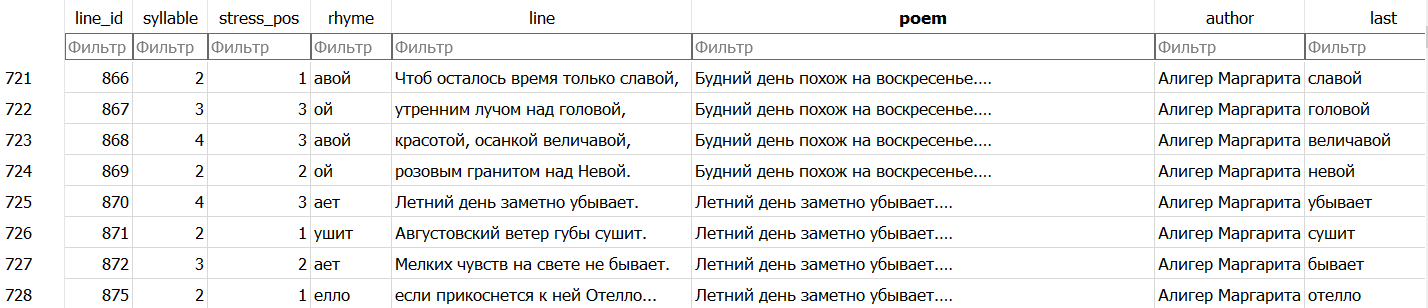

База данных собиралась с помощью краулера.

С сайта https://rupoem.ru/poets были собраны стихотворения 200 авторов (472744 строк).

Затем базу данных сократили, оставив только уникальные словоформы - всего получилось 99744.

1. Сбор данных:

In [9]:
session = requests.session()

In [10]:
ua = UserAgent(verify_ssl=False)

In [11]:
url = 'https://rupoem.ru/poets'
req = session.get(url, headers={'User-Agent': ua.random})
page = req.text

In [12]:
soup = BeautifulSoup(page, 'html.parser')

In [13]:
ids = soup.find_all('div', {'class': 'col-sm-4'})
href_p = []
for i in ids:
    href_p.append(('https://rupoem.ru' + i.find('a')['href'] + '/all.aspx', i.text[2:i.text.index('(')-1]))

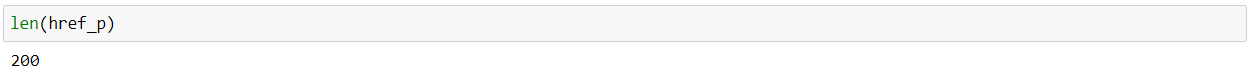

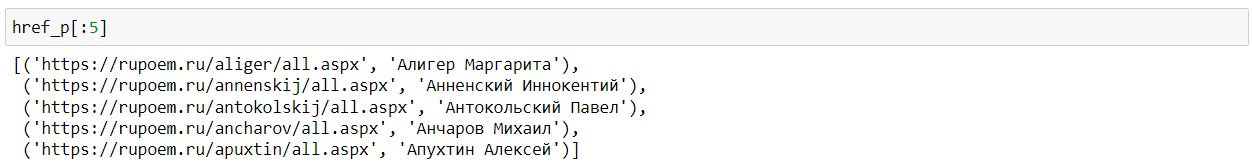

In [31]:
all_rhymes = []
for i in href_p:
    req = session.get(i[0], headers={'User-Agent': ua.random})
    page = req.text
    soup = BeautifulSoup(page, 'html.parser')
    poems = soup.find_all('div', {'class': 'poem-text font-size-larger'})
    for poem in poems:
        lines = poem.text.split('\n')
        for line in lines:
            try:
                tok_line = word_tokenize(accent_line(line))
                if tok_line:
                    last_word = find_word(tok_line)
                    if last_word and "'" not in last_word and count_vowels(last_word) > 1 and "ё" not in last_word:
                        last_word += "'"
                    syllable = count_vowels(last_word)
                    stress_pos = stress_position(last_word)
                    rhyme = ''
                    if syllable == 1:
                        rhyme = word_piece_1(last_word)
                    elif syllable and syllable > 1:
                        rhyme = word_piece(last_word)
                    all_rhymes.append((len(all_rhymes), syllable, stress_pos, rhyme, line.strip(), poem.text, i[1]))
            except IndexError:
                continue
print('done')

done


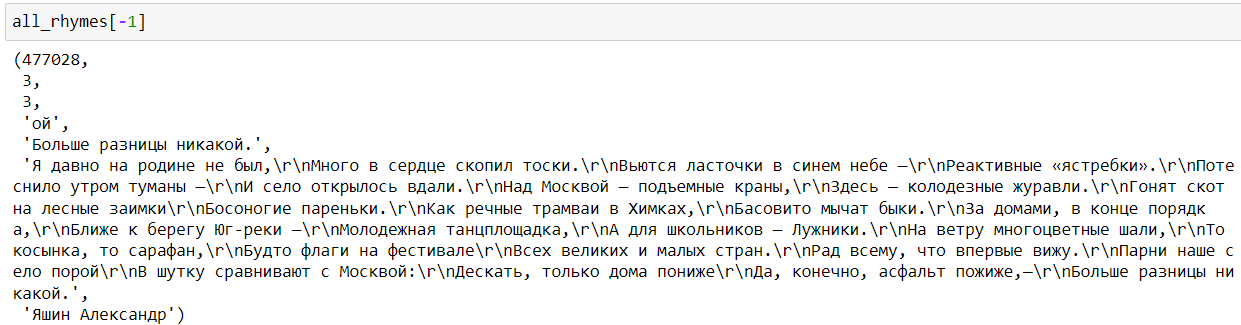

In [35]:
clean_rhymes = []
for i in all_rhymes:
    if None not in i and len(i) == 7 and i[1] != 0:
        clean_rhymes.append(i)

2. Добавление в базу данных:

In [70]:
conn = sqlite3.connect('rhy.db')

In [71]:
cur = conn.cursor()

In [100]:
cur.execute("""
CREATE TABLE rhymes (
    line_id INT,
    syllable INT, 
    stress_pos INT, 
    rhyme TEXT,
    line TEXT,
    poem TXT,
    author TXT,
    last TXT,
    PRIMARY KEY (line_id)
)
""")
conn.commit()

In [101]:
cur.executemany("INSERT INTO rhymes VALUES (?, ?, ?, ?, ?, ?, ?, ?)", all_rhymes)

In [102]:
conn.commit()
conn.close()

Примеры функций для обработки рифмы:

In [1]:
import requests
from pprint import pprint
from fake_useragent import UserAgent
import random
import sqlite3
from bs4 import BeautifulSoup
import re

In [2]:
from ru_accent_poet import accent_line

In [3]:
from nltk.tokenize import word_tokenize

In [4]:
# считает кол-во гласных (слогов)
def count_vowels(word):
    vowels = "аяоеуюыиэё"
    c_vowels = 0
    if word:
        for i in word:
            if i in vowels:
                c_vowels += 1
        return c_vowels

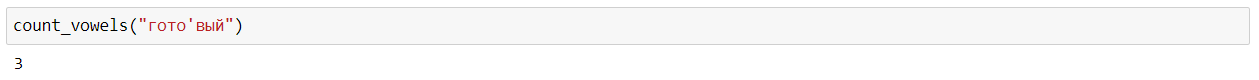

In [5]:
# находит номер ударного слога
def stress_position(stressed_word): # нужно слово уже с ударением - например, accent_line('учится')
    vowels = "аяоеуюыиэё"
    word_vowels = []
    flag = 0
    if stressed_word:
        for letter in stressed_word:
            flag += 1
            if letter in vowels:
                if flag != len(stressed_word):
                    if stressed_word[flag] == "'":
                        word_vowels.extend([letter, "+"])
                    else:
                        word_vowels.append(letter)
                else:
                    word_vowels.append(letter)
        if len(word_vowels) > 1:
            if "ё" not in stressed_word:
                try:
                    stressed_position = word_vowels.index("+")
                except ValueError:
                    return None
            else:
                stressed_position = word_vowels.index("ё")+1
        else:
            stressed_position = 1
        return stressed_position

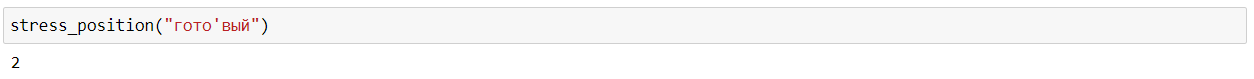

In [6]:
# для односложных слов
def word_piece_1(stressed_word):
    vowels = "аяоеуюыиэё"
    for i in stressed_word:
        if i in vowels and stressed_word[-1] == i:
            return stressed_word[stressed_word.index(i)-1:]
        elif i in vowels and stressed_word[-1] != i:
            return stressed_word[stressed_word.index(i):]

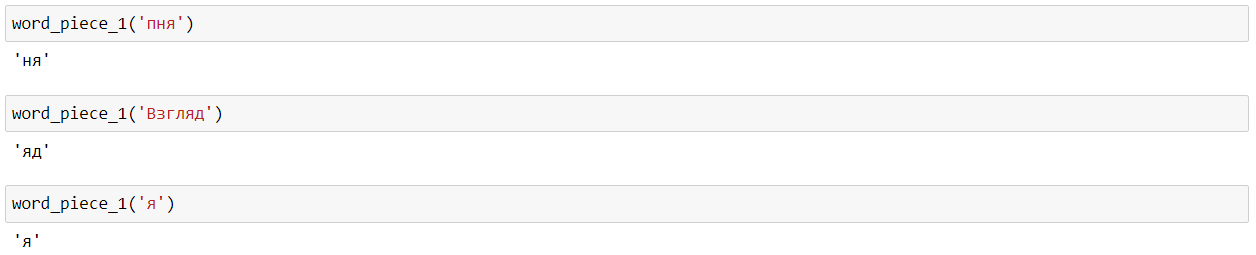

In [7]:
# для слов с более 1 слога
def word_piece(stressed_word):
    if "ё" in stressed_word:
        return stressed_word[stressed_word.index("ё"):]
    elif stressed_word[-1] == "'":
        return stressed_word[stressed_word.index("'")-2:].replace("'", '')
    elif "'" in stressed_word:
        return stressed_word[stressed_word.index("'")-1:].replace("'", '')

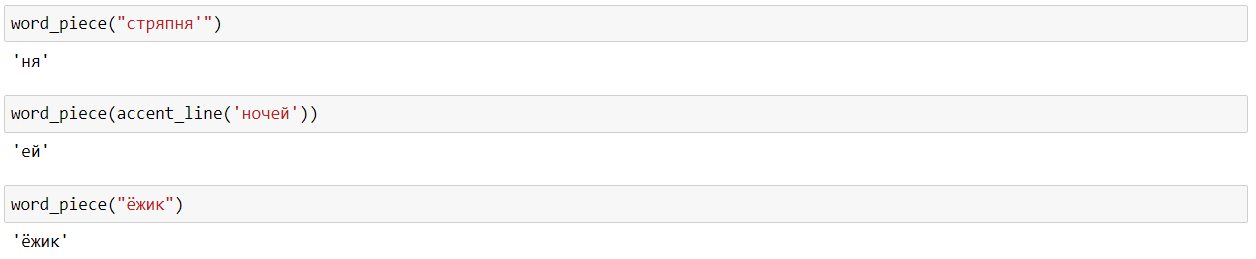

In [8]:
# ищет последнее слово в списке токенов
def find_word(line_lst):
    token = ''
    for t in reversed(line_lst):
        if re.search("[а-яА-Я]", t) and len(t) > 1:
            token = t
            break
        elif re.search("[а-яА-Я]", t) and len(t) == 1:
            new_list = list(reversed(line_lst))
            if new_list[new_list.index(t)+1] == "'":
                token = new_list[new_list.index(t)+2] + "'" + t
                break
            elif t == 'я' and new_list[new_list.index(t)+1] != "'":
                token = t
                break
            else:
                continue
    return token